In [79]:
import math
import os
import urllib.request
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt

torch.manual_seed(87)
torch.cuda.manual_seed(87)
print(plt.style.available)
plt.style.use('seaborn-v0_8')

DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
DEVICE = 'cpu'

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


Exact Gaussian Process Regression

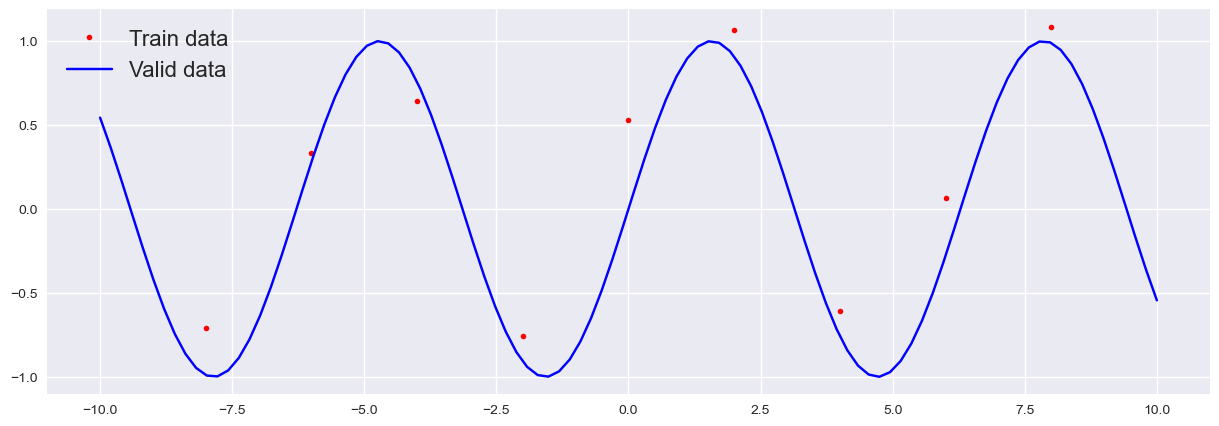

In [80]:
# create the data
sampling_frequency = 0.5
X_train = torch.arange(-8, 9, 1 / sampling_frequency)
Y_train = torch.sin(X_train) + 0.2 * torch.randn(len(X_train))
X_train, y_train = X_train.type(torch.float32), Y_train.type(torch.float32)

X_valid = torch.linspace(-10, 10, 100)
y_valid = torch.sin(X_valid)
X_valid, y_valid = X_valid.type(torch.float32), y_valid.type(torch.float32)

# plot the data
_, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(X_train, Y_train, 'ro', ms=4)
ax.plot(X_valid, y_valid, 'b-')
plt.legend(['Train data', 'Valid data'],
           fontsize=16)
plt.show()

In [81]:
# defining the module
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, likelihood, noise_init=None):
        super(ExactGPModel, self).__init__(
            likelihood=likelihood, train_inputs=None, train_targets=None)
        
        # Initialize the mean and covariance modules.
        self.mean_module = gpytorch.means.ConstantMean(dtype=torch.float32)
        self.covar_module = gpytorch.kernels.RBFKernel(dtype=torch.float32)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [82]:
# create the shorch module
from skorch.probabilistic import ExactGPRegressor

gpr = ExactGPRegressor(
    ExactGPModel,
    optimizer=torch.optim.Adam,
    likelihood=gpytorch.likelihoods.GaussianLikelihood(),
    lr=0.1,
    max_epochs=20,
    device=DEVICE,
    batch_size=-1)  # -1 for full batch

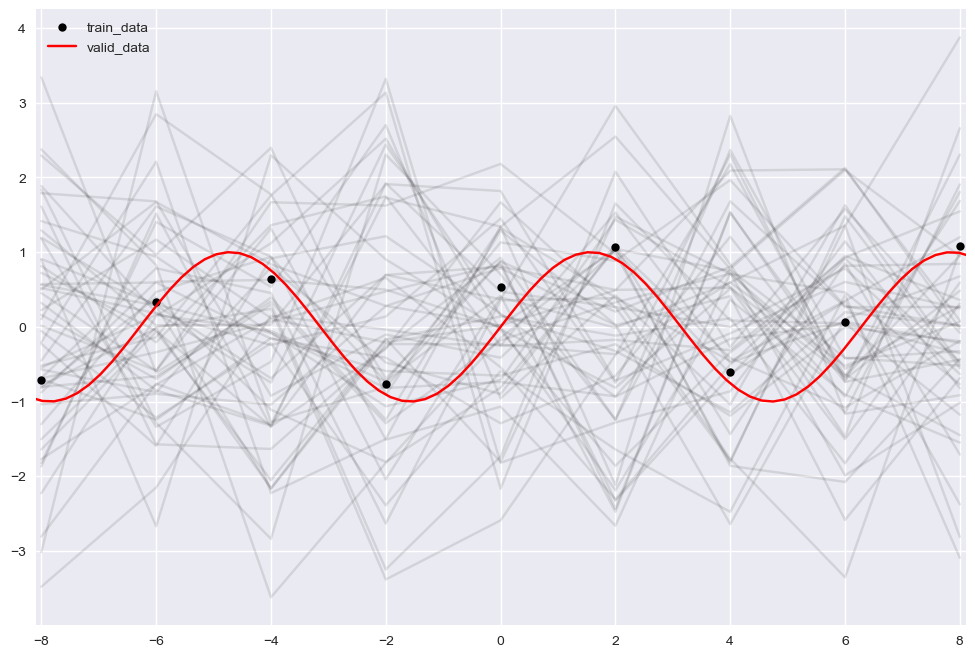

In [83]:
# sample from the underlying distribution conditioned on the training data
gpr.initialize()
samples = gpr.sample(X_train, n_samples=50)
samples = samples.cpu().detach().numpy()

# show some samples
_, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(X_train, samples.T, color='k', alpha=0.1)
ax.plot(X_train, Y_train, 'ko', ms=6, label='train_data')
ax.plot(X_valid, y_valid, 'r', label='valid_data')
ax.set_xlim([-8.1, 8.1])
ax.legend()
plt.show()

In [84]:
# fit the model
gpr.fit(X_train, y_train)

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        1.3327  0.0053
      2        1.3143  0.0025
      3        1.3020  0.0028
      4        1.2941  0.0018
      5        1.2865  0.0030
      6        1.2774  0.0024
      7        1.2675  0.0023
      8        1.2582  0.0017
      9        1.2502  0.0015
     10        1.2438  0.0014
     11        1.2382  0.0015
     12        1.2325  0.0018
     13        1.2266  0.0032
     14        1.2207  0.0016
     15        1.2153  0.0015
     16        1.2108  0.0018
     17        1.2071  0.0018
     18        1.2038  0.0019
     19        1.2006  0.0022
     20        1.1972  0.0018


<class 'skorch.probabilistic.ExactGPRegressor'>[initialized](
  module_=ExactGPModel(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
  ),
)

/opt/miniconda3/envs/pytorch/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


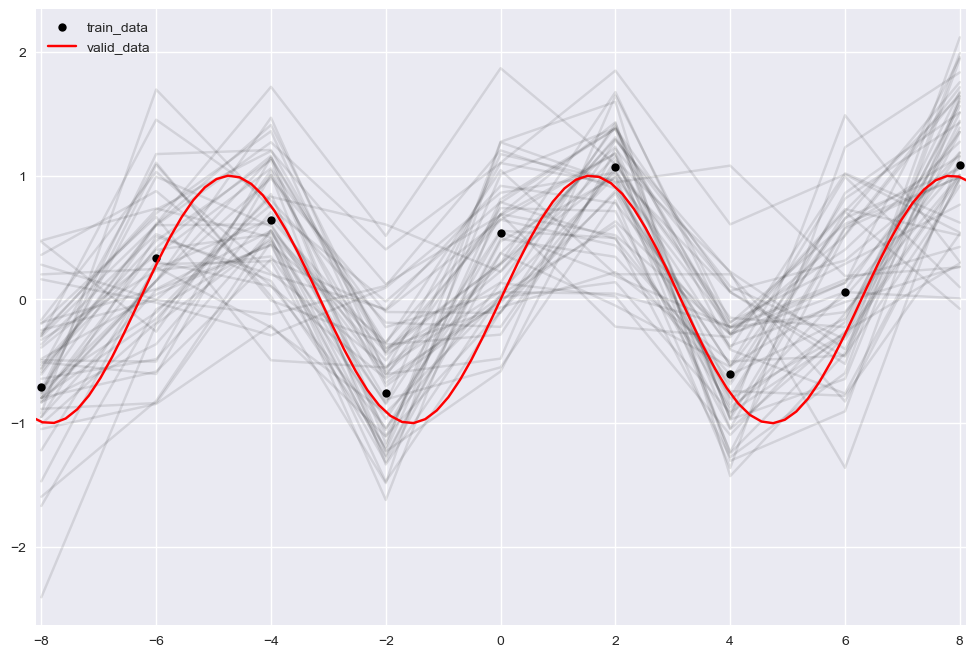

In [85]:
# analyze the trained model
samples = gpr.sample(X_train, n_samples=50)
samples = samples.cpu().detach().numpy()

_, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(X_train, samples.T, color='k', alpha=0.1)
ax.plot(X_train, Y_train, 'ko', ms=6, label='train_data')
ax.plot(X_valid, y_valid, 'r', label='valid_data')
ax.set_xlim([-8.1, 8.1])
ax.legend()
plt.show()

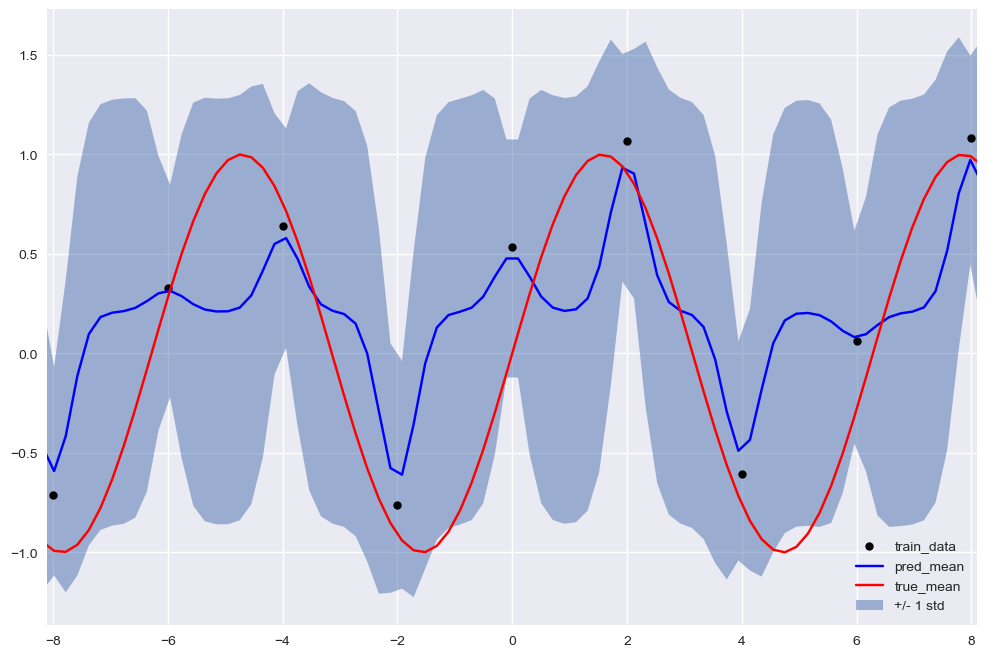

In [86]:
# plot some confidence intervals
y_pred, y_std = gpr.predict(X_valid, return_std=True)

_, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(X_train, Y_train, 'ko', ms=6, label='train_data')
ax.plot(X_valid, y_pred, 'b-', label='pred_mean')
ax.plot(X_valid, y_valid, 'r', label='true_mean')
ax.fill_between(
    X_valid, y_pred - y_std, y_pred + y_std,
    alpha=0.5, label='+/- 1 std')
ax.set_xlim([-8.1, 8.1])
ax.legend()
plt.show()

Increase the sampling frequency

In [87]:
# create the data
sampling_frequency = 2
X_train = torch.arange(-8, 9, 1 / sampling_frequency)
Y_train = torch.sin(X_train) + 0.2 * torch.randn(len(X_train))
X_train, y_train = X_train.type(torch.float32), Y_train.type(torch.float32)

# train the model
gpr = ExactGPRegressor(
    ExactGPModel,
    optimizer=torch.optim.Adam,
    likelihood=gpytorch.likelihoods.GaussianLikelihood(),
    lr=0.1,
    max_epochs=20,
    device=DEVICE,
    batch_size=-1)  # -1 for full batch

gpr.fit(X_train, y_train)

  epoch    train_loss     dur
-------  ------------  ------
      1        1.1584  0.0022
      2        1.1256  0.0021
      3        1.0922  0.0016
      4        1.0579  0.0031
      5        1.0233  0.0025
      6        0.9883  0.0033
      7        0.9528  0.0019
      8        0.9170  0.0017
      9        0.8811  0.0015
     10        0.8453  0.0021
     11        0.8097  0.0035
     12        0.7743  0.0035
     13        0.7394  0.0018
     14        0.7052  0.0020
     15        0.6718  0.0018
     16        0.6395  0.0015
     17        0.6084  0.0028
     18        0.5785  0.0019
     19        0.5499  0.0022
     20        0.5226  0.0027


<class 'skorch.probabilistic.ExactGPRegressor'>[initialized](
  module_=ExactGPModel(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
  ),
)

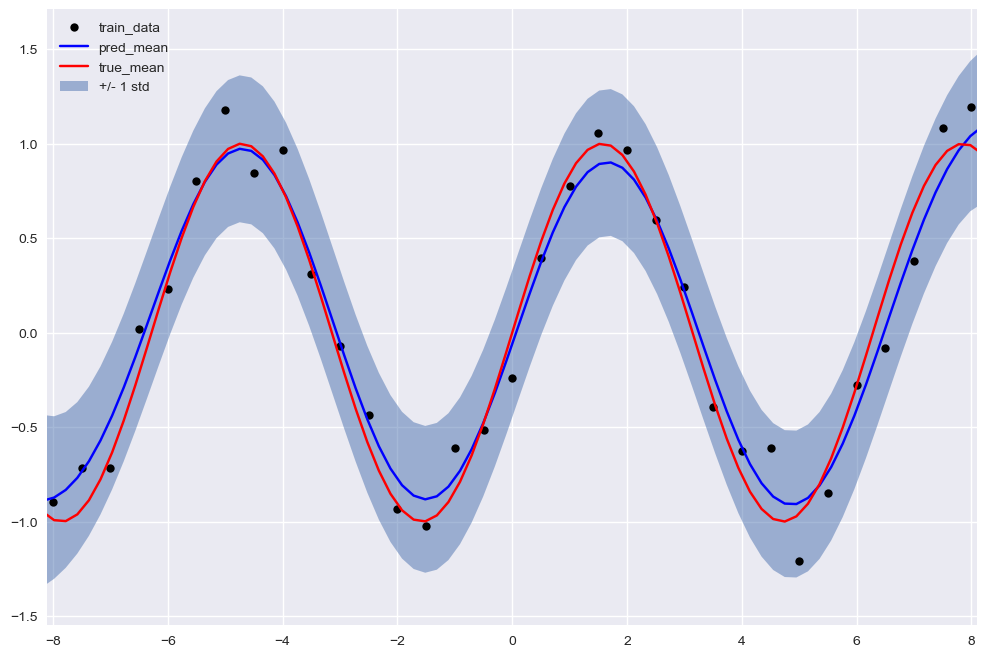

In [88]:
# plot some confidence intervals
y_pred, y_std = gpr.predict(X_valid, return_std=True)

_, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(X_train, Y_train, 'ko', ms=6, label='train_data')
ax.plot(X_valid, y_pred, 'b-', label='pred_mean')
ax.plot(X_valid, y_valid, 'r', label='true_mean')
ax.fill_between(
    X_valid, y_pred - y_std, y_pred + y_std,
    alpha=0.5, label='+/- 1 std')
ax.set_xlim([-8.1, 8.1])
ax.legend()
plt.show()

Confidence region

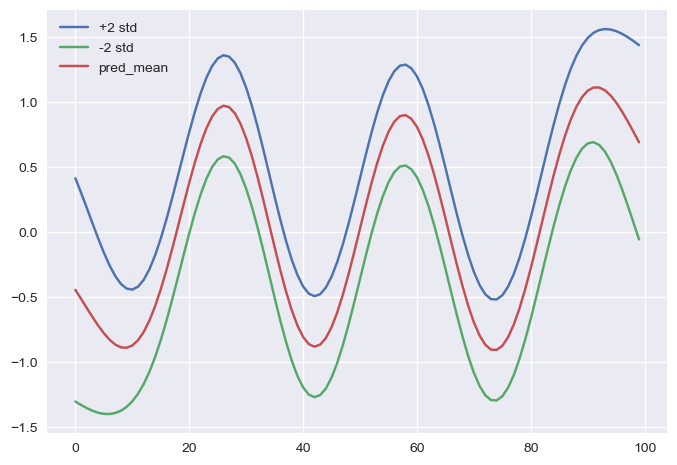

In [89]:
lower, upper = gpr.confidence_region(X_valid, sigmas=1)

plt.figure()
plt.plot(upper, label='+2 std')
plt.plot(lower, label='-2 std')
plt.plot(y_pred, label='pred_mean')
plt.legend()
plt.show()

Perform a grid search

In [90]:
from sklearn.model_selection import GridSearchCV

params = {
    'lr': [0.01, 0.02, 0.03],
    'max_epochs': [10, 20],
}

gpr = ExactGPRegressor(
    ExactGPModel,
    optimizer=torch.optim.Adam,
    likelihood=gpytorch.likelihoods.GaussianLikelihood(),
    device=DEVICE,
    batch_size=-1)  # -1 for full batch

grid_search = GridSearchCV(gpr, params,
                           cv=3, verbose=1,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1655  0.0023
      2        1.1623  0.0423
      3        1.1590  0.0110
      4        1.1558  0.0031
      5        1.1526  0.0019
      6        1.1493  0.0018
      7        1.1461  0.0016
      8        1.1428  0.0026
      9        1.1396  0.0042
     10        1.1363  0.0022
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1700  0.0012
      2        1.1669  0.0021
      3        1.1637  0.0017
      4        1.1606  0.0019
      5        1.1575  0.0019
      6        1.1544  0.0019
      7        1.1513  0.0017
      8        1.1481  0.0026
      9        1.1450  0.0017
     10        1.1418  0.0015
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1519  0.0014
      2        1.1485  0.0016
      3        1.1451  0.0016
      4        1.1418  0.0023
      5        1.1384  0.0019
      6   

Regression with real world data

In [ ]:
from sklearn.preprocessing import StandardScaler

path = os.path.join('data', 'BART_sample.pt')
url = 'https://drive.google.com/uc?export=download&id=1A6LqCHPA5lHa5S3lMH8mLMNEgeku8lRG'
if not os.path.isfile(path):
    print('Downloading BART sample dataset...')
    urllib.request.urlretrieve(url, path)
    
train_x, train_y, test_x, test_y = torch.load(path,
                                              weights_only=False,
                                              map_location=DEVICE)

# scale the data
train_x_min, train_x_max = train_x.min(), train_x.max()

X_train = train_x - train_x_min
X_valid = test_x - train_x_min

y_scaler = StandardScaler().fit(train_y.T)
y_train = torch.from_numpy(y_scaler.transform(train_y.T).T).float()
y_valid = torch.from_numpy(y_scaler.transform(test_y.T).T).float()

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

torch.Size([5, 1440, 1]) torch.Size([5, 1440]) torch.Size([5, 240, 1]) torch.Size([5, 240])


In [ ]:
# Defining the module
class SpetralDeltaGP(gpytorch.models.ExactGP):
    def __init__(self, X, y, likelihood,
                 num_deltas, noise_init=None):
        super(SpetralDeltaGP, self).__init__(X, y, likelihood)
        
        # Initialize the mean and covariance modules.
        self.mean_module = gpytorch.means.ConstantMean()
        base_covar_module = gpytorch.kernels.SpectralDeltaKernel(
            num_deltas=num_deltas,
            num_dims=X.size(-1))
        self.covar_module = gpytorch.kernels.ScaleKernel(base_covar_module)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        

In [97]:
# Defining a custom likeihood
def get_likelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-11),
    noise_prior=gpytorch.priors.HorseshoePrior(0.1),
    noise=1e-2,
):
    likelihood = gpytorch.likelihoods.GaussianLikelihood(
        noise_constraint=noise_constraint,
    )
    likelihood.register_prior('noise_prior', noise_prior, 'noise')
    likelihood.noise = noise
    return likelihood

In [101]:
# create the skorch module
gpr = ExactGPRegressor(
    SpetralDeltaGP,
    module__num_deltas=1500,
    module__X=X_train,
    module__y=y_train,
    
    optimizer=torch.optim.Adam,
    # likelihood=get_likelihood,
    lr=2e-4,
    max_epochs=50,
    device=DEVICE,
    batch_size=-1)  # -1 for full batch

In [100]:
# training the model
# with gpytorch.settings.max_cholesky_size(0):
gpr.fit(X_train, y_train)

Re-initializing module because the following parameters were re-set: X, num_deltas, y.
Re-initializing criterion.
Re-initializing optimizer.


NotImplementedError: 